<a href="https://colab.research.google.com/github/farukemrekaraca/ztm-tensorflow-machinelearning-deeplearning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Thu Feb  1 06:49:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-01 06:49:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-01 06:49:32 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-01 06:49:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 142.250.97.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   239MB/s    in 0.7s    

2024-02-01 06:49:37 (239 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [8]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[254.35715    246.35715    200.73979   ]
   [252.07143    245.92857    198.07143   ]
   [250.27551    244.91837    192.55103   ]
   ...
   [250.63776    244.63776    229.35205   ]
   [251.40308    245.40308    232.11736   ]
   [252.35715    246.35715    234.35715   ]]

  [[252.73979    244.73979    198.73979   ]
   [249.41837    243.27551    195.41837   ]
   [244.71428    239.35713    189.11224   ]
   ...
   [247.14285    240.14285    221.21428   ]
   [249.2143     242.2143     224.35715   ]
   [251.09694    244.02551    226.38266   ]]

  [[250.21939    242.21939    196.21939   ]
   [245.98468    238.91325    192.91325   ]
   [247.64285    241.2857     195.07143   ]
   ...
   [246.78574    239.78574    213.35716   ]
   [247.85716    240.07144    216.42859   ]
   [249.06636    241.06636    219.63779   ]]

  ...

  [[246.         219.21426    101.785736  ]
   [246.19896    219.41322    101.984695  ]
   [247.04591    220.26018    102.83165   ]
   ...
   [249.         224.   

In [13]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="globl_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")])

24274472/24274472 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240201-064948
Epoch 1/5
24/24 [==============================] - 20s 291ms/step - loss: 1.8559 - accuracy: 0.4253 - val_loss: 1.3327 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 4s 132ms/step - loss: 1.1333 - accuracy: 0.7467 - val_loss: 0.9082 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 4s 139ms/step - loss: 0.8405 - accuracy: 0.7933 - val_loss: 0.7487 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 4s 131ms/step - loss: 0.7014 - accuracy: 0.8307 - val_loss: 0.6496 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 4s 173ms/step - loss: 0.5954 - accuracy: 0.8680 - val_loss: 0.6129 - val_accuracy: 0.8405


In [14]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 0.5666 - accuracy: 0.8608


[0.566585898399353, 0.86080002784729]

In [15]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [17]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 globl_average_pooling_laye  (None, 1280)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


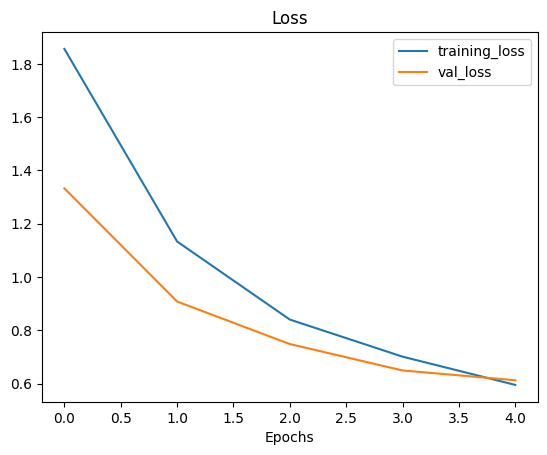

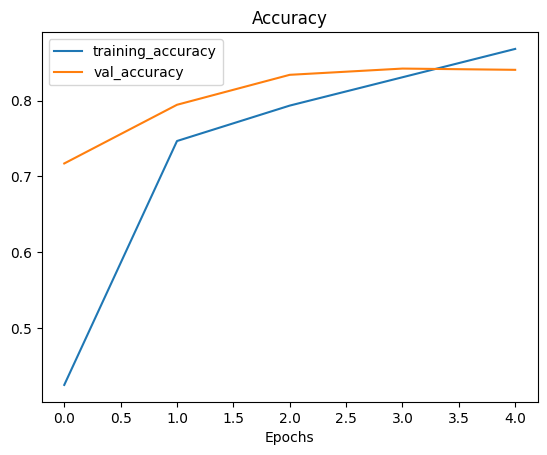

In [18]:
plot_loss_curves(history_10_percent)

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-02-01 06:50:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 172.253.123.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   103MB/s    in 1.2s    

2024-02-01 06:50:39 (103 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [22]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.rescale(1/255.) necessary for resnet50v2, efficientnet has built
], name="data_augmentation")

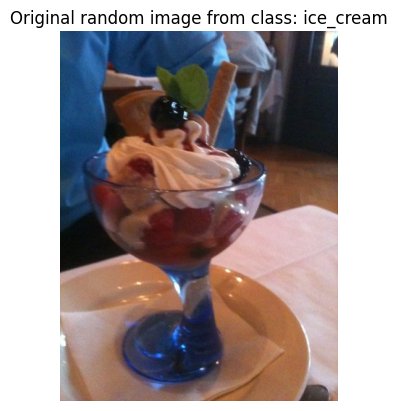

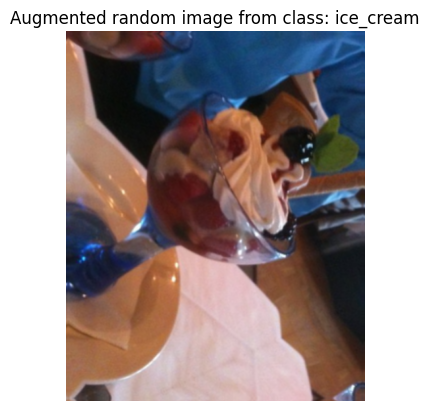

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [25]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240201-065046
Epoch 1/5
3/3 [==============================] - 17s 3s/step - loss: 2.4218 - accuracy: 0.1714 - val_loss: 2.1991 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1907 - accuracy: 0.1429 - val_loss: 2.0877 - val_accuracy: 0.2336
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 2.0077 - accuracy: 0.3429 - val_loss: 1.9908 - val_accuracy: 0.3010
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.9438 - accuracy: 0.3857 - val_loss: 1.9104 - val_accuracy: 0.3816
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.7749 - accuracy: 0.5000 - val_loss: 1.8299 - val_accuracy: 0.4622


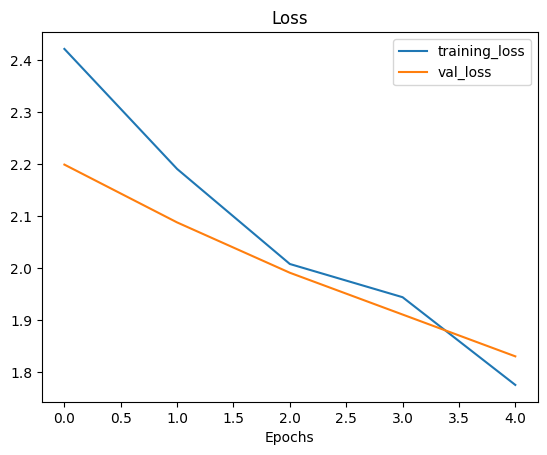

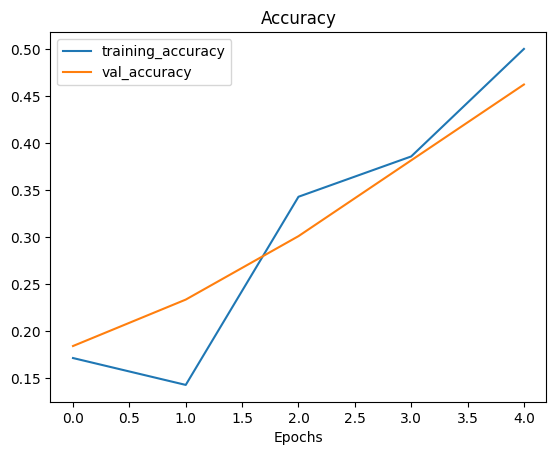

In [26]:
plot_loss_curves(history_1_percent)

In [27]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [28]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_Data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [57]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [58]:
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="1_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240201-070354
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.7800
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 581ms/step - loss: 0.6636 - accuracy: 0.7800 - val_loss: 0.5091 - val_accuracy: 0.8388
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.8360
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 642ms/step - loss: 0.4938 - accuracy: 0.8360 - val_loss: 0.4308 - val_accuracy: 0.8520
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.9013
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 664ms/step - loss: 0.3321 - accuracy: 0.9013 - val_loss: 0.5484 - val_accuracy: 0.8273
Ep

In [59]:
model_2.load_weights(checkpoint_path)

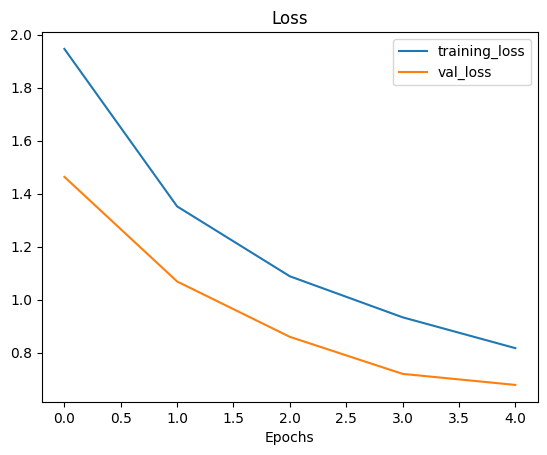

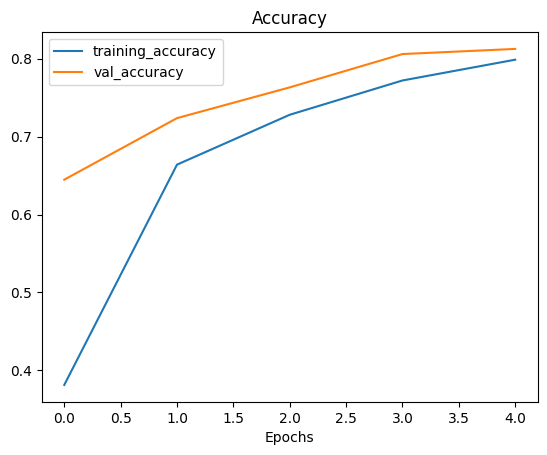

In [32]:
plot_loss_curves(history_10_percent_data_aug)

In [33]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6563 - accuracy: 0.8304


In [60]:
model_2.load_weights(checkpoint_path)

In [35]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.6563 - accuracy: 0.8304


In [36]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [37]:
model_2.layers

In [38]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79b011e08e80> True
<keras.src.engine.sequential.Sequential object at 0x79b011e08e20> True
<keras.src.engine.functional.Functional object at 0x79b011426740> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x79b0114a2170> True
<keras.src.layers.core.dense.Dense object at 0x79b011447fd0> True


In [39]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [61]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [62]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [63]:
model_2.load_weights(checkpoint_path)

In [64]:
# recompile upon changes
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(0.0001), # reduce lr on fine tuning
                metrics=["accuracy"])

In [65]:
model_2.load_weights(checkpoint_path)

In [42]:
print(len(model_2.trainable_variables))

12


In [66]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240201-070743
Epoch 5/10
24/24 [==============================] - 26s 663ms/step - loss: 0.2016 - accuracy: 0.9413 - val_loss: 0.5299 - val_accuracy: 0.8586
Epoch 6/10
24/24 [==============================] - 17s 702ms/step - loss: 0.1558 - accuracy: 0.9493 - val_loss: 0.5378 - val_accuracy: 0.8487
Epoch 7/10
24/24 [==============================] - 13s 531ms/step - loss: 0.1143 - accuracy: 0.9747 - val_loss: 0.6148 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0919 - accuracy: 0.9707 - val_loss: 0.5803 - val_accuracy: 0.8388
Epoch 9/10
24/24 [==============================] - 13s 525ms/step - loss: 0.0961 - accuracy: 0.9747 - val_loss: 0.5228 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 12s 451ms/step - loss: 0.0969 - accuracy: 0.9707 - val_loss: 0.5490 - val_accuracy: 0.8388


In [71]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.4649 - accuracy: 0.8584


In [72]:
results_10_percent_data_aug

[0.6562982201576233, 0.8303999900817871]

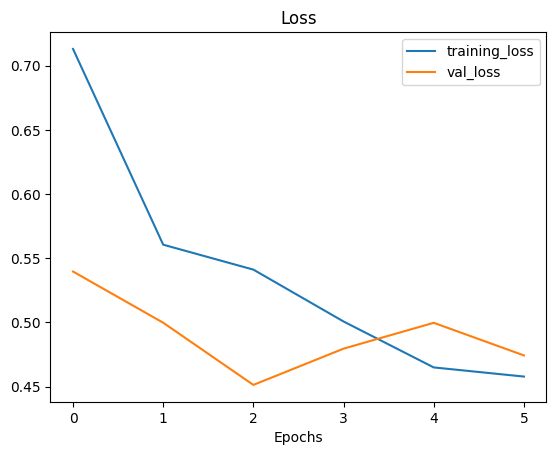

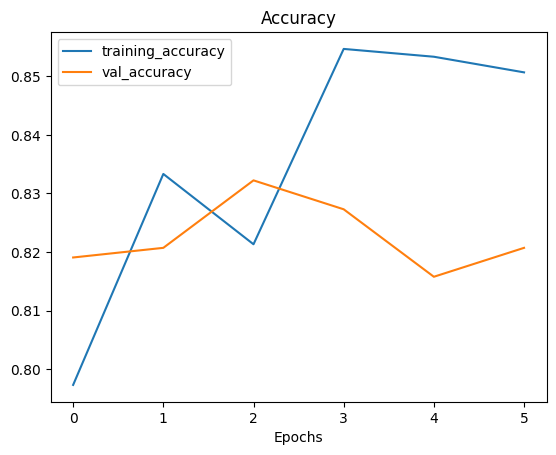

In [46]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [47]:
def compare_histories(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

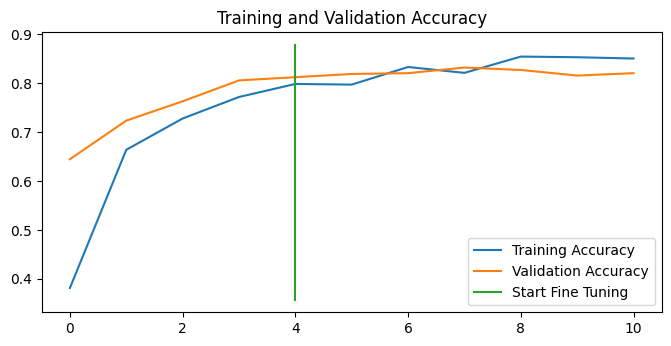

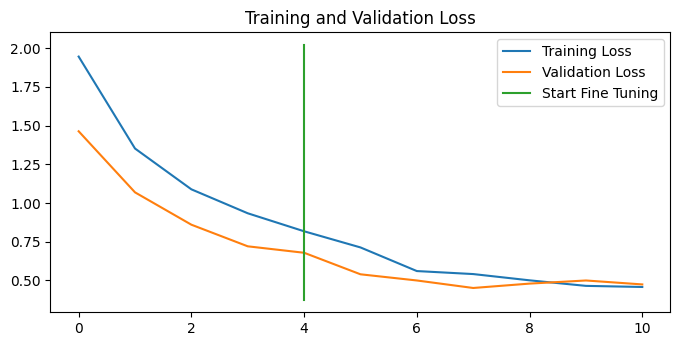

In [48]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

In [49]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2024-02-01 06:56:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.213.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  85.0MB/s    in 5.1s    

2024-02-01 06:56:47 (97.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [50]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [51]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [52]:
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [69]:
model_2.load_weights(checkpoint_path)

In [70]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 111ms/step - loss: 0.4649 - accuracy: 0.8584


[0.4648644030094147, 0.8583999872207642]

In [76]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [77]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [79]:
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20240201-072357
Epoch 5/10
235/235 [==============================] - 110s 422ms/step - loss: 0.6049 - accuracy: 0.8085 - val_loss: 0.3707 - val_accuracy: 0.8783
Epoch 6/10
235/235 [==============================] - 102s 435ms/step - loss: 0.5295 - accuracy: 0.8321 - val_loss: 0.3268 - val_accuracy: 0.8997
Epoch 7/10
235/235 [==============================] - 86s 361ms/step - loss: 0.4806 - accuracy: 0.8460 - val_loss: 0.3373 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - 72s 304ms/step - loss: 0.4460 - accuracy: 0.8581 - val_loss: 0.3085 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 64s 269ms/step - loss: 0.4231 - accuracy: 0.8656 - val_loss: 0.2829 - val_accuracy: 0.9161
Epoch 10/10
235/235 [==============================] - 64s 269ms/step - loss: 0.4110 - accuracy: 0.8684 - val_loss: 0.2873 - val_accuracy: 0.9112


In [81]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 8s 83ms/step - loss: 0.2498 - accuracy: 0.9192


[0.24980229139328003, 0.9192000031471252]

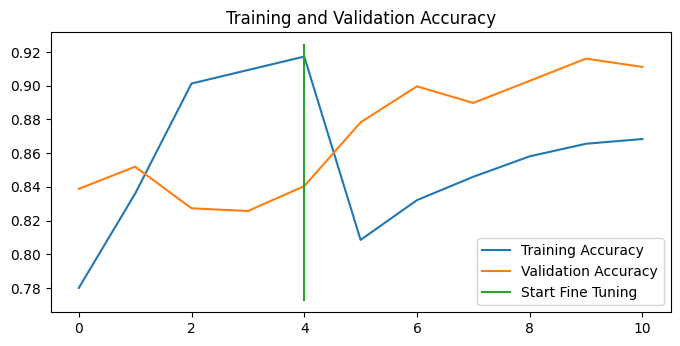

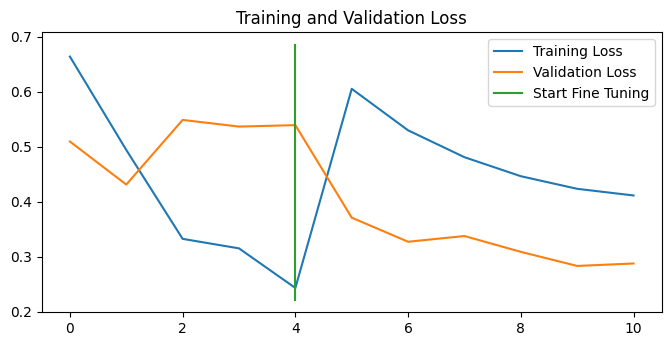

In [82]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_classes_full,
                  5)